## **IMPORT**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from ChessCore import *
from ChessEngine import *
from numba import cuda, types
import time
import math

## **TESTS**

### TEST FUNCTIONS ON THE CPU

#### Move generation test function on CPU

*Input:*
- `fen`: FEN string representing the current state of the game
- `king_moves_only`: Whether you want to see all possible moves or only the king's moves (Optional, default: `False`)
- `plot_moves`: Whether you want to plot the board after each of the possible moves (Optional, default: `False`)

*Output:* 
- Plots the board and all querried moves
- Measures execution time

In [2]:
def chess_move_generation_test_cpu(fen: str = None, king_moves_only: bool = False, plot_moves: bool = False):
    game = ChessGame() if fen is None else ChessGame(fen)

    start = time.time()
    moves = game.generate_all_moves()
    end = time.time()

    print(f'Execution time: {end - start} s')

    if king_moves_only:
        king_position = game.get_king_position(game.side_to_move())
        if king_position >= 0:
            moves = [move for move in moves if move.start_position() == king_position]

    if plot_moves:
        num_moves = len(moves)
        if num_moves > 0:
            cols = math.ceil(math.sqrt(num_moves))
            rows = math.ceil(num_moves / cols)

            fig, axs = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows))

            row, col = 0, 0

            for move in moves:
                game_copy = game.copy()
                game_copy.move(move)
                game_copy.plot(moves=[move], ax=axs[row, col] if rows > 1 else axs[col])
                col += 1
                if col >= cols:
                    col = 0
                    row += 1

            while row < rows:
                (axs[row, col] if rows > 1 else axs[col]).set_visible(False)
                col += 1
                if col >= cols:
                    col = 0
                    row += 1
        else:
            print('No move found')

    else:
        game.plot(moves=moves)

#### Game tree node count test function on CPU

*Input:*
- `fen`: FEN string representing the current state of the game
- `search_depth`: Depth of the search tree

*Output:* 
- Number of nodes of the game tree

In [3]:
def chess_moves_count_test_cpu_recursive(game: ChessGame, search_depth: int = 1):
    count = 1

    if search_depth > 0:
        moves = game.generate_all_moves()
        for move in moves:
            game_copy = game.copy()
            game_copy.move(move)
            count += chess_moves_count_test_cpu_recursive(game_copy, search_depth - 1)
            del game_copy

    return count

def chess_moves_count_test_cpu(fen: str = None, search_depth: int = 1):
    return chess_moves_count_test_cpu_recursive(ChessGame() if fen is None else ChessGame(fen), search_depth)

### TEST FUNCTIONS ON THE GPU

#### Move generation test function on GPU

*Input:*
- `fen`: FEN string representing the current state of the game
- `king_moves_only`: Whether you want to see all possible moves or only the king's moves (Optional, default: `False`)
- `plot_moves`: Whether you want to plot the board after each of the possible moves (Optional, default: `False`)

*Output:* 
- Plots the board and all querried moves
- Measures execution time

In [4]:
@cuda.jit
def generate_moves_kernel(board, side, castle_WK, castle_WQ, castle_BK, castle_BQ, en_passant_target, halfmoves, out_moves, out_count):
    count, _ = generate_all_moves_device(board, side, castle_WK, castle_WQ, castle_BK, castle_BQ, en_passant_target, halfmoves, out_moves)
    out_count[0] = count

@cuda.jit
def move_kernel(board, side, infos, move):
    castling_right    = infos[0]
    en_passant_target = infos[1]
    halfmove          = infos[2]

    castle_WK = (castling_right & 0x01 != 0)
    castle_WQ = (castling_right & 0x02 != 0)
    castle_BK = (castling_right & 0x04 != 0)
    castle_BQ = (castling_right & 0x08 != 0)

    side, castle_WK, castle_WQ, castle_BK, castle_BQ, en_passant_target, halfmove = move_device(board, side, move, castle_WK, castle_WQ, castle_BK, castle_BQ, en_passant_target, halfmove)

    castling_right = 0x00
    if castle_WK:
        castling_right |= (1 << 0)
    if castle_WQ:
        castling_right |= (1 << 1)
    if castle_BK:
        castling_right |= (1 << 2)
    if castle_BQ:
        castling_right |= (1 << 3)

    infos[0] = castling_right
    infos[1] = en_passant_target
    infos[2] = halfmove

def encode_move(move: Move):
    promote_to = 0x00 if move.promote_to() is None else move.promote_to()
    if (promote_to & 0x07) != 0:
        promote_to = (promote_to & 0x07) - 2

    res = 0x00

    res |= (move.start_position() & 0xFF) << 0 
    res |= (move.end_position()   & 0xFF) << 8
    res |= promote_to << 16
    res |= (1 << 19) if move.en_passant_target() is not None else 0

    return res

def chess_move_generation_test_gpu(fen: str = None, king_moves_only: bool = False, plot_moves: bool = False):
    game = ChessGame() if fen is None else ChessGame(fen)

    start = time.time()
    d_board     = cuda.to_device(np.array(game.get_board(), dtype=np.int8))
    d_out_moves = cuda.device_array(256, dtype=np.int32)
    d_out_count = cuda.device_array(1, dtype=np.int32)
    generate_moves_kernel[1, 1](d_board, game.side_to_move(), game.m_castle_WK, game.m_castle_WQ, game.m_castle_BK, game.m_castle_BQ, 
        -1 if game.m_en_passant_target is None else game.m_en_passant_target, game.get_halfmove(), d_out_moves, d_out_count)
    out_moves = d_out_moves.copy_to_host()
    out_count = d_out_count.copy_to_host()[0]
    moves = [move for move in out_moves[:out_count]]
    end = time.time()

    print(f'Execution time: {end - start} s')

    if king_moves_only:
        king_position = game.get_king_position(game.side_to_move())
        if king_position >= 0:
            moves = [move for move in moves if decode_move(game.side_to_move(), move).start_position() == king_position]

    if plot_moves:
        num_moves = len(moves)
        if num_moves > 0:
            cols = math.ceil(math.sqrt(num_moves))
            rows = math.ceil(num_moves / cols)

            fig, axs = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows), squeeze = False)

            row, col = 0, 0

            for move in moves:
                game_copy = game.copy()
                castling_right = 0x00
                if game_copy.m_castle_WK:
                    castling_right |= (1 << 0)
                if game_copy.m_castle_WQ:
                    castling_right |= (1 << 1)
                if game_copy.m_castle_BK:
                    castling_right |= (1 << 2)
                if game_copy.m_castle_BQ:
                    castling_right |= (1 << 3)
                infos = [castling_right, -1 if game_copy.m_en_passant_target is None else game_copy.m_en_passant_target, game_copy.m_halfmove]

                d_board = cuda.to_device(np.array(game_copy.m_board, dtype = np.int8))
                d_infos = cuda.to_device(np.array(infos, dtype = np.int32))

                move_kernel[1, 1](d_board, game_copy.m_current_side, d_infos, move)

                game_copy.set_board(list(d_board.copy_to_host()))

                infos = d_infos.copy_to_host()

                castling_right = infos[0]
                game_copy.m_castle_WK = (castling_right & 0x01 != 0)
                game_copy.m_castle_WQ = (castling_right & 0x02 != 0)
                game_copy.m_castle_BK = (castling_right & 0x04 != 0)
                game_copy.m_castle_BQ = (castling_right & 0x08 != 0)

                game_copy.m_en_passant_target = None if infos[1] == -1 else infos[1]

                game_copy.m_halfmove = infos[2]

                game_copy.m_current_side = not game_copy.m_current_side
                
                game_copy.plot(moves=[decode_move(move, game.side_to_move())], ax = axs[row, col])
                col += 1
                if col >= cols:
                    col = 0
                    row += 1

            while row < rows:
                (axs[row, col] if rows > 1 else axs[col]).set_visible(False)
                col += 1
                if col >= cols:
                    col = 0
                    row += 1
        else:
            print('No move found')

    else:
        game.plot(moves=[decode_move(move, game.side_to_move()) for move in moves])

#### Game tree node count test function on GPU

*Input:*
- `fen`: FEN string representing the current state of the game
- `search_depth`: Depth of the search tree

*Output:* 
- Number of nodes of the game tree

In [5]:
def chess_moves_count_test_gpu_recursive(game: ChessGame, search_depth: int = 1):
    count = 1

    if search_depth > 0:
        d_board     = cuda.to_device(np.array(game.get_board(), dtype=np.int32))
        d_out_moves = cuda.device_array(256, dtype=np.int32)
        d_out_count = cuda.device_array(1, dtype=np.int32)
        generate_moves_kernel[1, 1](d_board, game.side_to_move(), game.m_castle_WK, game.m_castle_WQ, game.m_castle_BK, game.m_castle_BQ, -1 if game.   m_en_passant_target is None else game.m_en_passant_target, game.get_halfmove(), d_out_moves, d_out_count)
        out_moves = d_out_moves.copy_to_host()
        out_count = d_out_count.copy_to_host()[0]
        moves = [decode_move(game.side_to_move(), move) for move in out_moves[:out_count]]

        for move in moves:
            game_copy = game.copy()
            castling_right = 0x00
            if game_copy.m_castle_WK:
                castling_right |= (1 << 0)
            if game_copy.m_castle_WQ:
                castling_right |= (1 << 1)
            if game_copy.m_castle_BK:
                castling_right |= (1 << 2)
            if game_copy.m_castle_BQ:
                castling_right |= (1 << 3)
            infos = [castling_right, -1 if game_copy.m_en_passant_target is None else game_copy.m_en_passant_target, game_copy.m_halfmove]

            d_board = cuda.to_device(np.array(game_copy.get_board(), dtype = np.int8))
            d_infos = cuda.to_device(np.array(infos, dtype = np.int32))

            move_kernel[1, 1](d_board, game_copy.m_current_side, d_infos, encode_move(move))

            game_copy.m_board = list(d_board.copy_to_host())
            infos             = d_infos.copy_to_host()

            castling_right = infos[0]
            game_copy.m_castle_WK = (castling_right & 0x01 != 0)
            game_copy.m_castle_WQ = (castling_right & 0x02 != 0)
            game_copy.m_castle_BK = (castling_right & 0x04 != 0)
            game_copy.m_castle_BQ = (castling_right & 0x08 != 0)

            game_copy.m_en_passant_target = None if infos[1] == -1 else infos[1]

            game_copy.m_halfmove = infos[2]
            game_copy.m_current_side = not game_copy.m_current_side
            
            count += chess_moves_count_test_gpu_recursive(game_copy, search_depth - 1)
            del game_copy

    return count

def chess_moves_count_test_gpu(fen: str = None, search_depth: int = 1):
    return chess_moves_count_test_gpu_recursive(ChessGame() if fen is None else ChessGame(fen), search_depth)

### TEST 1: Default layout

- Default pieces placement
- White moves
- Castling rights:
    - White: king's side, queen's side
    - Black: king's side, queen's side

Execution time: 0.0 s


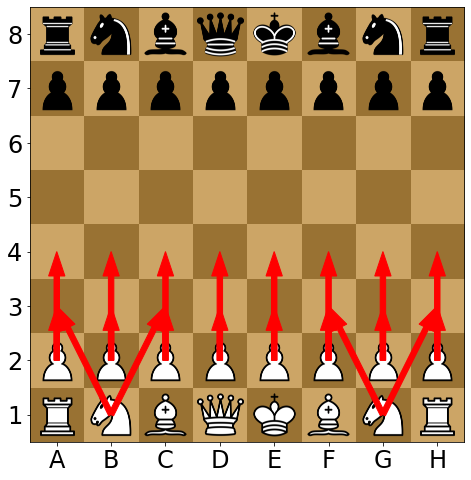

In [6]:
chess_move_generation_test_cpu()

Execution time: 8.84471082687378 s


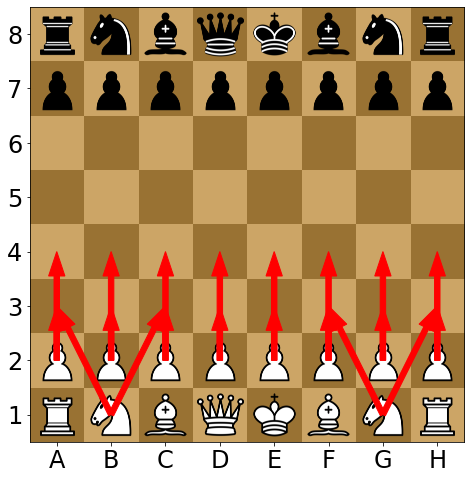

In [7]:
chess_move_generation_test_gpu()

In [8]:
moves_count_cpu = chess_moves_count_test_cpu(search_depth = 4)
moves_count_gpu = chess_moves_count_test_gpu(search_depth = 4)
print(f'Number of moves generated on CPU: {moves_count_cpu}')
print(f'Number of moves generated on GPU: {moves_count_gpu}')

Number of moves generated on CPU: 206604
Number of moves generated on GPU: 206604


### TEST 2: Castling

- White king and rooks didn't moved, black king moved
- White moves
- Castling rights:
    - White: king's side, queen's side
    - Black: none

*Note: Only king's moves are shown here to prevent confusion*

Execution time: 0.0012881755828857422 s


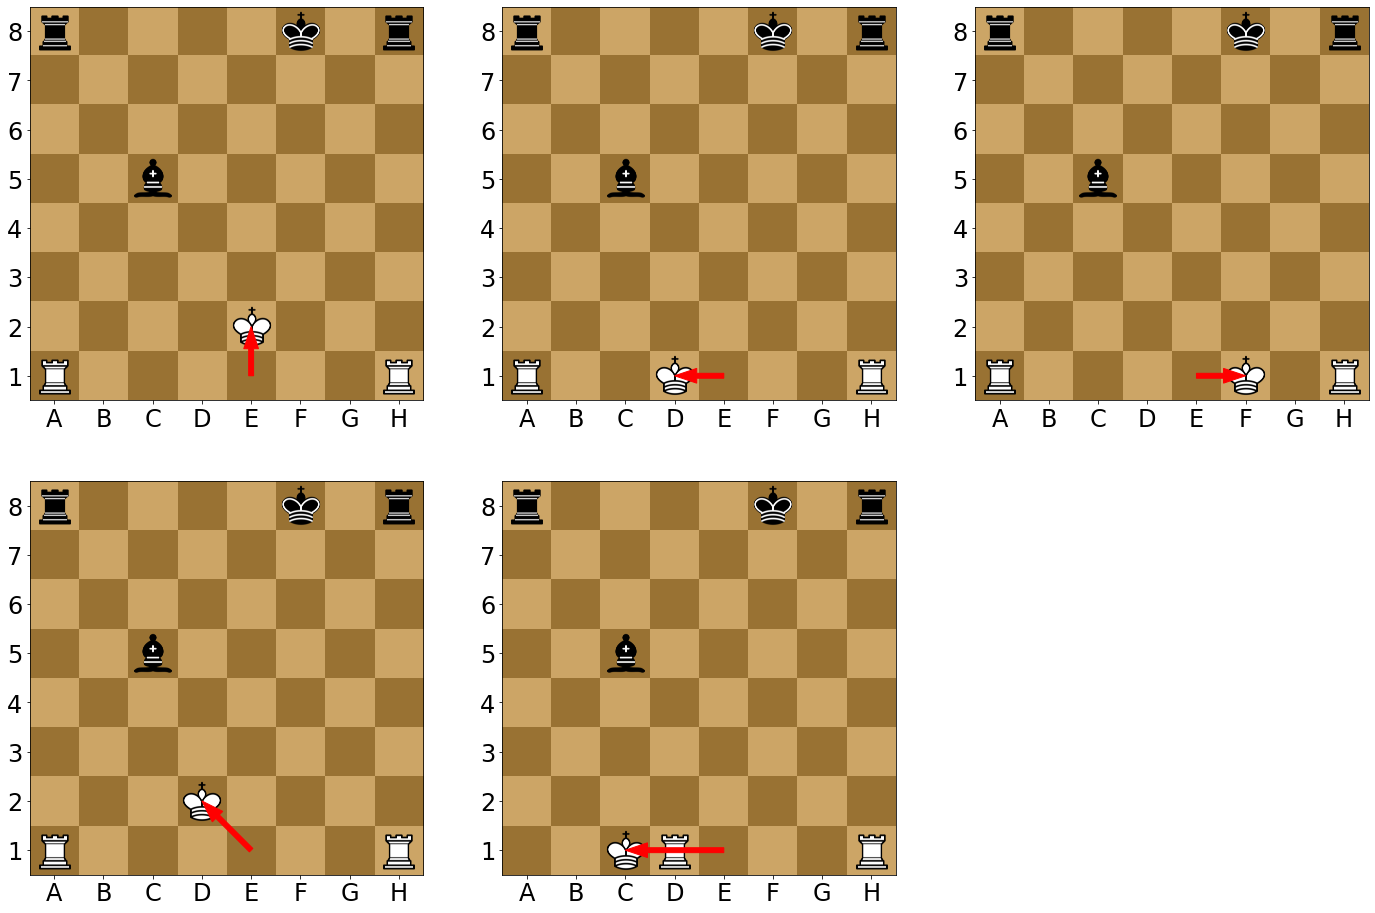

In [9]:
chess_move_generation_test_cpu('r4k1r/8/8/2b5/8/8/8/R3K2R w KQ - 0 42', king_moves_only=True, plot_moves=True)

Execution time: 0.0020067691802978516 s


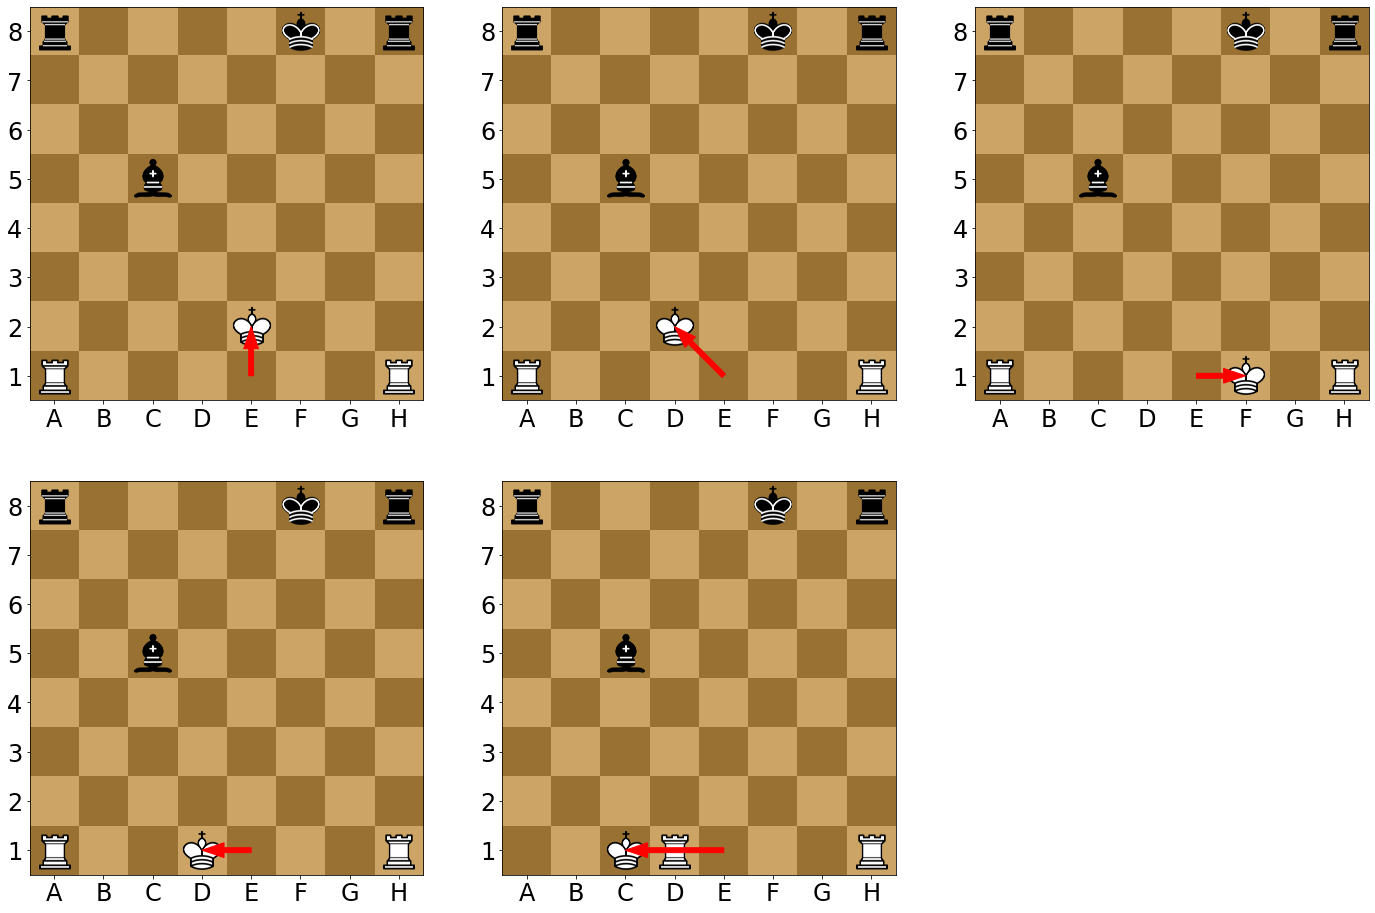

In [10]:
chess_move_generation_test_gpu('r4k1r/8/8/2b5/8/8/8/R3K2R w KQ - 0 42', king_moves_only=True, plot_moves=True)

In [11]:
moves_count_cpu = chess_moves_count_test_cpu(fen = 'r4k1r/8/8/2b5/8/8/8/R3K2R w KQ - 0 42', search_depth = 4)
moves_count_gpu = chess_moves_count_test_gpu(fen = 'r4k1r/8/8/2b5/8/8/8/R3K2R w KQ - 0 42', search_depth = 4)
print(f'Number of moves generated on CPU: {moves_count_cpu}')
print(f'Number of moves generated on GPU: {moves_count_gpu}')

Number of moves generated on CPU: 445200
Number of moves generated on GPU: 445200


### TEST 3: Pinned

- Black pawn is pinned by white queen and shouldn't be able to move
- Black moves
- Castling rights:
    - White: none
    - Black: none

Execution time: 0.0 s


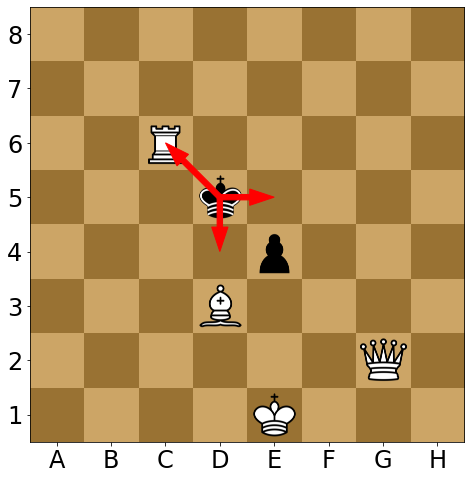

In [12]:
chess_move_generation_test_cpu('8/8/2R5/3k4/4p3/3B4/6Q1/4K3 b - - 0 1')

Execution time: 0.002001523971557617 s


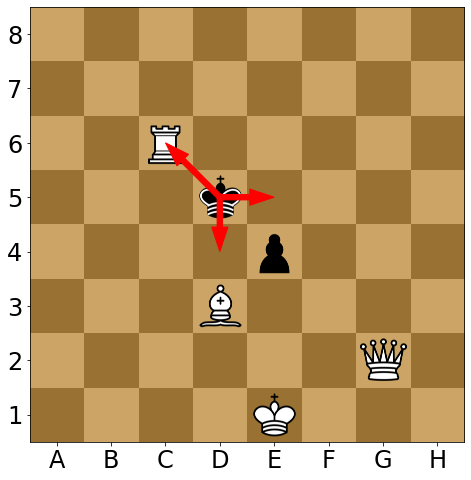

In [13]:
chess_move_generation_test_gpu('8/8/2R5/3k4/4p3/3B4/6Q1/4K3 b - - 0 1')

In [14]:
moves_count_cpu = chess_moves_count_test_cpu(fen = '8/8/2R5/3k4/4p3/3B4/6Q1/4K3 b - - 0 1', search_depth = 4)
moves_count_gpu = chess_moves_count_test_gpu(fen = '8/8/2R5/3k4/4p3/3B4/6Q1/4K3 b - - 0 1', search_depth = 4)
print(f'Number of moves generated on CPU: {moves_count_cpu}')
print(f'Number of moves generated on GPU: {moves_count_gpu}')

Number of moves generated on CPU: 26738
Number of moves generated on GPU: 26738


### TEST 4: Checked

- Black king is currently in check, and can either move away, block with the knight or capture the rook
- Black moves
- Castling rights:
    - White: none
    - Black: none

Execution time: 0.0 s


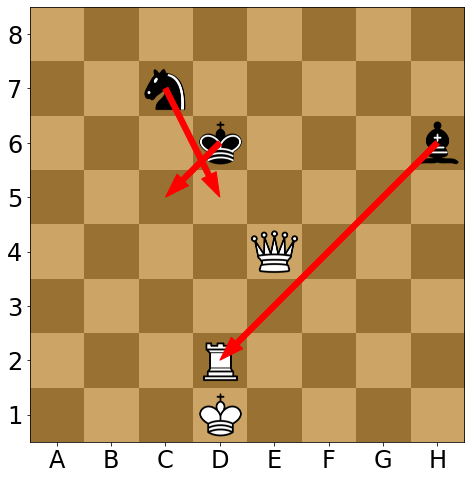

In [15]:
chess_move_generation_test_cpu('8/2n5/3k3b/8/4Q3/8/3R4/3K4 b - - 0 1')

Execution time: 0.002017498016357422 s


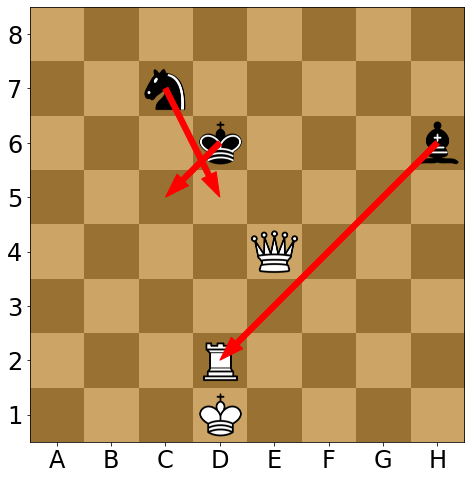

In [16]:
chess_move_generation_test_gpu('8/2n5/3k3b/8/4Q3/8/3R4/3K4 b - - 0 1')

In [17]:
moves_count_cpu = chess_moves_count_test_cpu(fen = '8/2n5/3k3b/8/4Q3/8/3R4/3K4 b - - 0 1', search_depth = 4)
moves_count_gpu = chess_moves_count_test_gpu(fen = '8/2n5/3k3b/8/4Q3/8/3R4/3K4 b - - 0 1', search_depth = 4)
print(f'Number of moves generated on CPU: {moves_count_cpu}')
print(f'Number of moves generated on GPU: {moves_count_gpu}')

Number of moves generated on CPU: 43602
Number of moves generated on GPU: 43602


### TEST 5: En passant

- White pawn has just moved up 2 spaces, and therefore can be captured via En passant
- Black moves
- Castling rights:
    - White: none
    - Black: none

Execution time: 0.0 s


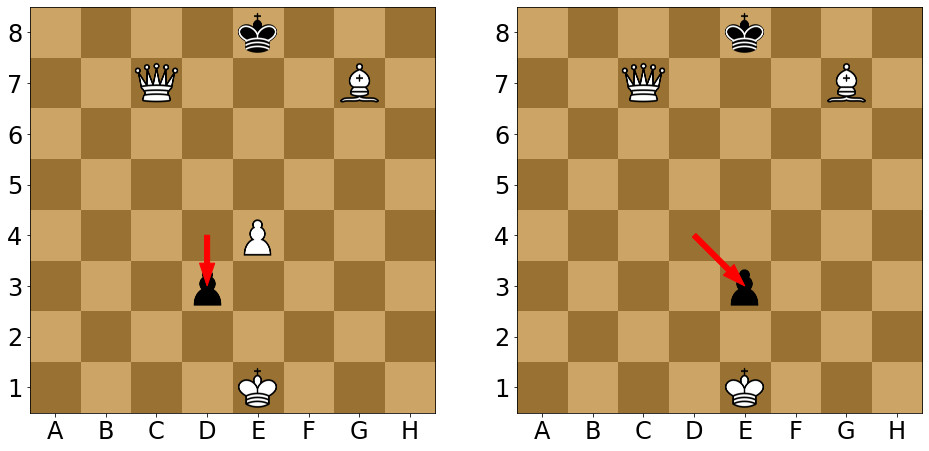

In [18]:
chess_move_generation_test_cpu('4k3/2Q3B1/8/8/3pP3/8/8/4K3 b - e3 0 1', plot_moves=True)

Execution time: 0.0032052993774414062 s


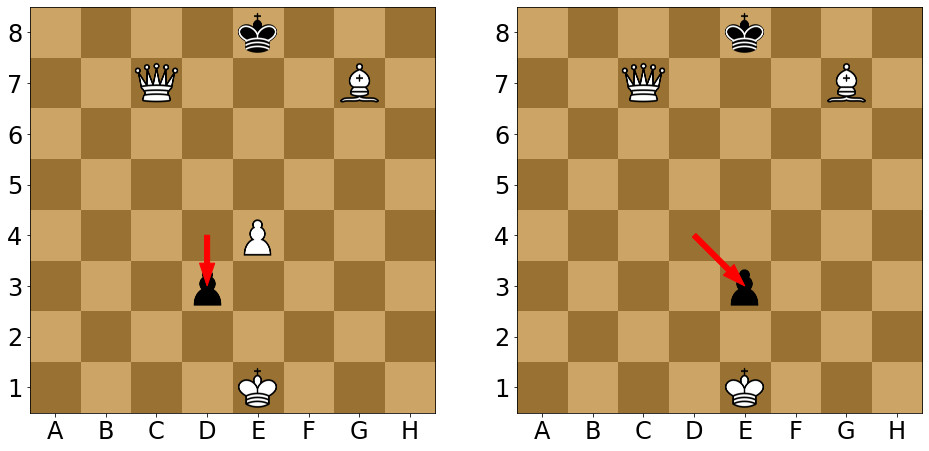

In [19]:
chess_move_generation_test_gpu('4k3/2Q3B1/8/8/3pP3/8/8/4K3 b - e3 0 1', plot_moves=True)

In [20]:
moves_count_cpu = chess_moves_count_test_cpu(fen = '4k3/2Q3B1/8/8/3pP3/8/8/4K3 b - e3 0 1', search_depth = 4)
moves_count_gpu = chess_moves_count_test_gpu(fen = '4k3/2Q3B1/8/8/3pP3/8/8/4K3 b - e3 0 1', search_depth = 4)
print(f'Number of moves generated on CPU: {moves_count_cpu}')
print(f'Number of moves generated on GPU: {moves_count_gpu}')

Number of moves generated on CPU: 5248
Number of moves generated on GPU: 5248


### TEST 6: Pawn's promotion

- White pawn is about to reach rank 8 and promote
- White moves
- Castling rights:
    - White: none
    - Black: none

Execution time: 0.0 s


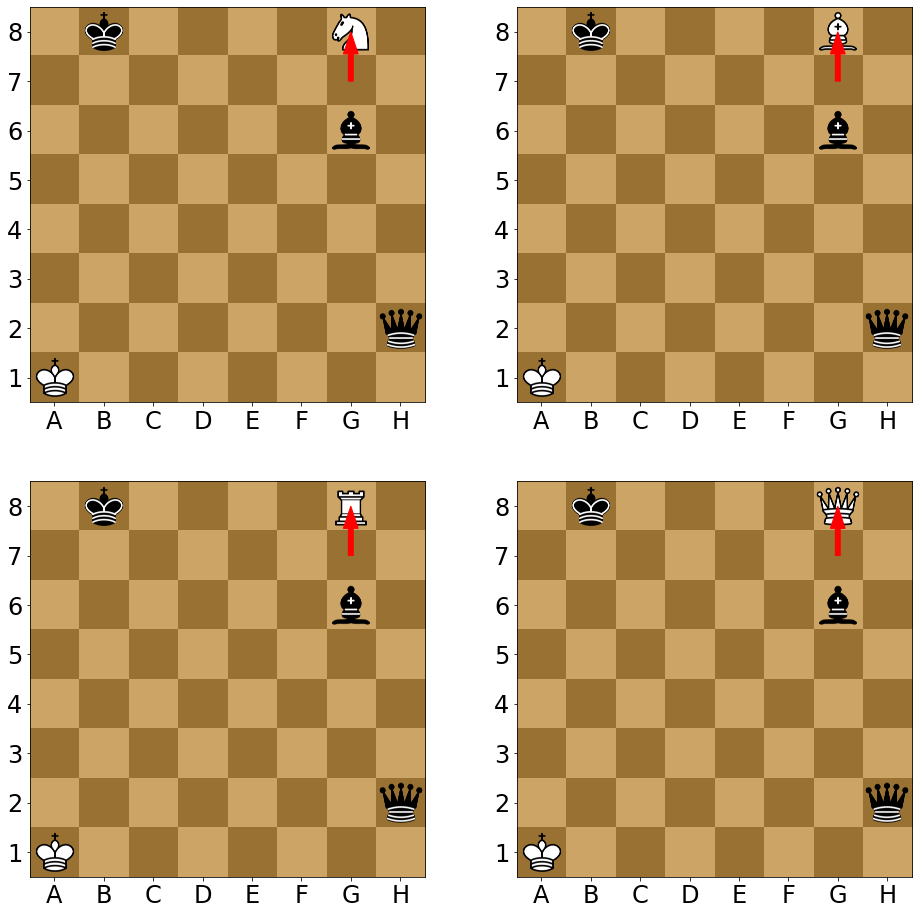

In [21]:
chess_move_generation_test_cpu('1k6/6P1/6b1/8/8/8/7q/K7 w - - 0 1', plot_moves=True)

Execution time: 0.002044677734375 s


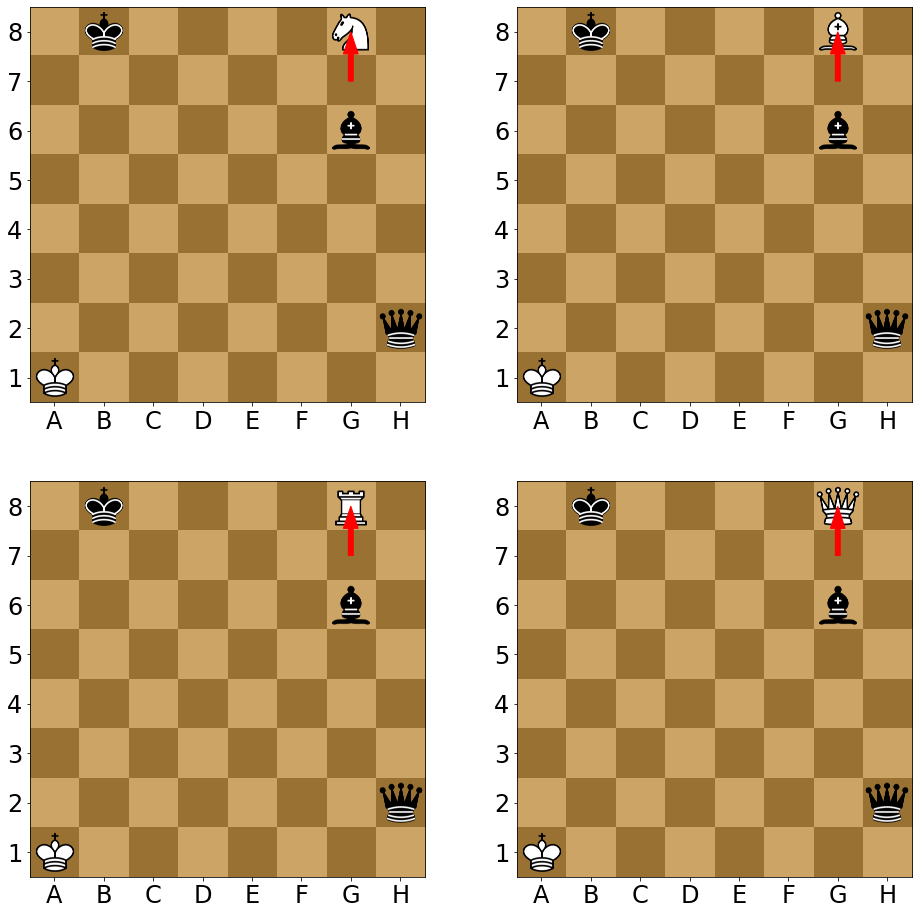

In [22]:
chess_move_generation_test_gpu('1k6/6P1/6b1/8/8/8/7q/K7 w - - 0 1', plot_moves=True)

In [23]:
moves_count_cpu = chess_moves_count_test_cpu(fen = '1k6/6P1/6b1/8/8/8/7q/K7 w - - 0 1', search_depth = 4)
moves_count_gpu = chess_moves_count_test_gpu(fen = '1k6/6P1/6b1/8/8/8/7q/K7 w - - 0 1', search_depth = 4)
print(f'Number of moves generated on CPU: {moves_count_cpu}')
print(f'Number of moves generated on GPU: {moves_count_gpu}')

Number of moves generated on CPU: 13937
Number of moves generated on GPU: 13937


### TEST 7: En passant special case

- Rare special case where if white captures via En passant it would create a check
- White moves
- Castling rights:
    - White: none
    - Black: none

Execution time: 0.0 s


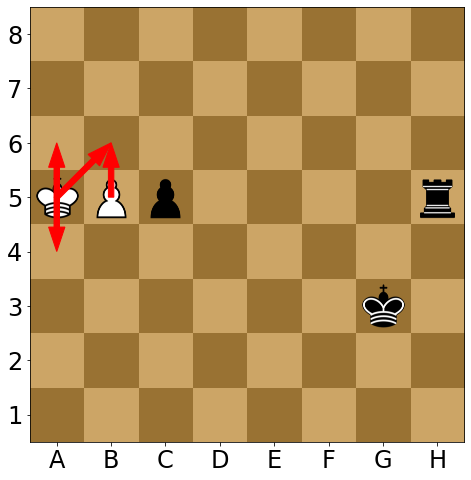

In [24]:
chess_move_generation_test_cpu('8/8/8/KPp4r/8/6k1/8/8 w - c6 0 1')

Execution time: 0.002020120620727539 s


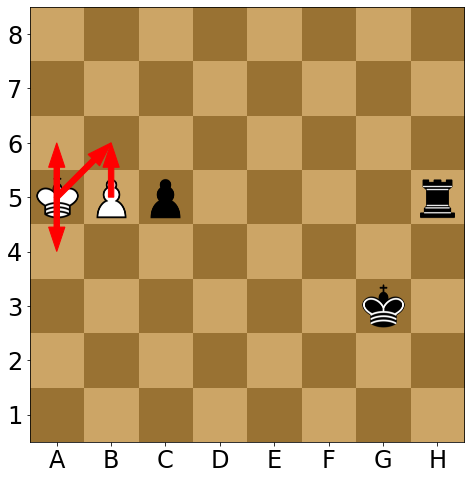

In [25]:
chess_move_generation_test_gpu('8/8/8/KPp4r/8/6k1/8/8 w - c6 0 1')

In [26]:
moves_count_cpu = chess_moves_count_test_cpu(fen = '8/8/8/KPp4r/8/6k1/8/8 w - c6 0 1', search_depth = 4)
moves_count_gpu = chess_moves_count_test_gpu(fen = '8/8/8/KPp4r/8/6k1/8/8 w - c6 0 1', search_depth = 4)
print(f'Number of moves generated on CPU: {moves_count_cpu}')
print(f'Number of moves generated on GPU: {moves_count_gpu}')

Number of moves generated on CPU: 7764
Number of moves generated on GPU: 7764


### TEST 8: Random case

- Nothing special
- Black moves
- Castling rights:
    - White: king's side, queen's side
    - Black: king's side, queen's side

Execution time: 0.0 s


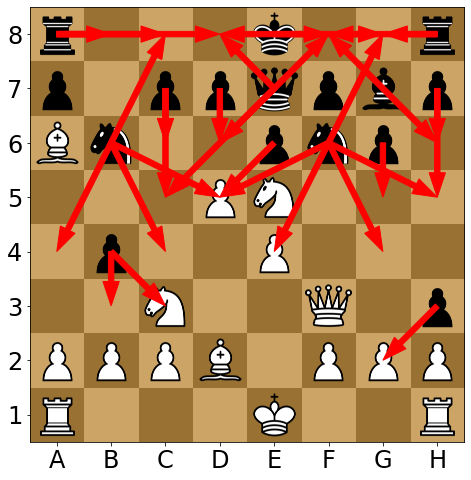

In [27]:
chess_move_generation_test_cpu('r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1')

Execution time: 0.0020935535430908203 s


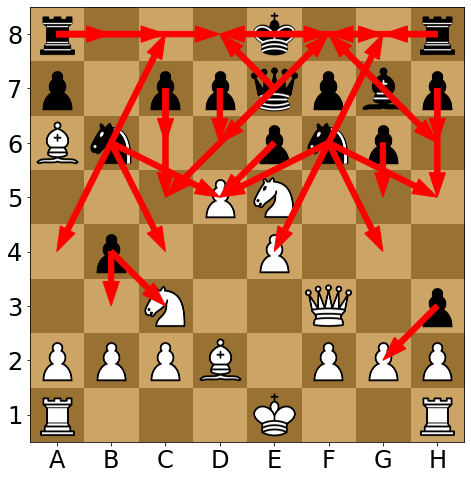

In [28]:
chess_move_generation_test_gpu('r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1')

In [29]:
moves_count_cpu = chess_moves_count_test_cpu(fen = 'r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1', search_depth = 4)
moves_count_gpu = chess_moves_count_test_gpu(fen = 'r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1', search_depth = 4)
print(f'Number of moves generated on CPU: {moves_count_cpu}')
print(f'Number of moves generated on GPU: {moves_count_gpu}')

Number of moves generated on CPU: 3107697
Number of moves generated on GPU: 3107697
